In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd 'drive/My Drive/Thesis'

Mounted at /content/drive/
/content/drive/My Drive/Thesis


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# import uniform distribution
from scipy.stats import uniform
from scipy.stats import binom
from scipy.stats import norm
import scipy.special as sc
import scipy.optimize
from scipy.optimize import fsolve
import time
from scipy.stats import truncnorm
np.random.seed(5)

In [2]:
def auction_exp(data_auction, p):
    """Train a normalizing flow model with maximum likelihood.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        dataset: dataset containing data to fit. Dataset
        batch_size: number of samples per batch. int
        max_epochs: number of training epochs. int
        frequency: frequency for plotting density visualization. int
        
    Return:
        model: trained model. Flow or StackedFlows
        losses: loss evolution during training. list of floats
    """
    revenue = 0
    for bid in data_auction:
        if bid >= p:
          #change the bidder with price p
          revenue += p
    
    revenue = revenue/len(data_auction)
    return revenue

In [3]:
def rejection_sampling(pi1, pi2):

  # def f(x):
  #   return [x[0] * (1 + np.log(x[1]/x[0])) - u,
  #           x[0] *(2*x[1]-x[0]) - u**2 - sigma**2]


  # root = fsolve(f, [ini1,ini2])
    
  # pi1 = min(root)
  # pi2 = max(root)
  #using rejection sampling, get N random price samples
  N = 10000
  n = 0
  #A =(pi2/pi1-1)*(pi2-pi1)/don
  don = pi2*np.log(pi2/pi1) - (pi2-pi1)
  env =(pi2/pi1-1)/don
  rej_sample =[]
  while(n <= N):
    x = uniform.rvs(loc=pi1, scale=pi2-pi1)
    a = (pi2/x-1)/don/env
    u1 = uniform.rvs()
    if (u1 <= a):
      rej_sample.append(x)
      n += 1
  return rej_sample

In [8]:
u = 1
sigma =1
myclip_a = 0
myclip_b = np.inf
#computer alpha beta for truncated normal distribution
a, b = (myclip_a - u) / sigma, myclip_b
k = 1/(1-norm.cdf(0, loc = u,scale = sigma))
x = 2
print(k*(norm.cdf(x, loc = u,scale = sigma)-norm.cdf(0, loc = u,scale = sigma)))
print(truncnorm.pdf(x, a , b ,loc = u,scale = sigma))
print(k*norm.pdf(x, loc = u,scale = sigma))

0.8114265826549397
0.2875999709391784
0.2875999709391784


In [3]:
m = 10
np.arange(0, m)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [43]:
# Experiment Randomisation first compute the log-lottery with truncated normal distribution:
sigma_list = []
DAPX_tnorm = []
r_list =[]

p_d_list = []

p_opt_list =[]

def F(x):
    return x-((1-k*(norm.cdf(x, loc = u,scale = sigma)-norm.cdf(0, loc = u,scale = sigma)))/(k*norm.pdf(x, loc = u,scale = sigma)))

def f_int(x):
  return (x * (1 + np.log(k2/(x**2) + 1) - np.log(2)) -mean )
 
def f_d(x):
   return ((x-1)**3)/((2*x-1)**2) - r**2   


APX_tnorm_list = []

step1 =np.linspace(0, 1,50)
step2 =np.linspace(1, 6,10)
n = 10000
myclip_a = 0
myclip_b = np.inf
u = 1
tic = time.clock()
step = np.concatenate((step1,step2))
#step = np.linspace(0, 1,1)
for i in step:
  sigma = 0.01 + i
  #computer alpha beta for truncated normal distribution
  a, b = (myclip_a - u) / sigma, myclip_b
  
  #constant of truncated normal distribution
  k = 1/(1-norm.cdf(0, loc = u,scale = sigma))
  mean, var = truncnorm.stats(a , b ,loc = u,scale = sigma, moments='mv')


  bid_tnorm = truncnorm.rvs(a , b , loc = u,scale = sigma,size=n)

  r = np.sqrt(var)/mean
  r_list.append(r)
  sigma_list.append(np.sqrt(var))
  p_opt = fsolve(F, mean-0.1)
  
  p_opt_list.append(p_opt)
  
  p_d = fsolve(f_d, [mean])
  p_d_list.append(p_d)
  reserve_p = p_d*mean/(2*p_d-1)
  print(F(p_opt))
  print(f_d(p_d))
  opt = auction_exp(bid_tnorm,p_opt)
  exp_revenue = auction_exp(bid_tnorm,reserve_p)

  DAPX_tnorm.append((opt/exp_revenue)[0])    

  #use truncated normal mean and variance to compute second moment
  k2 = mean**2 + var
  pi1 = fsolve(f_int, [mean-0.1])
  pi2 = 0.5*(k2/pi1 +pi1)  
  print(f_int(pi1))
  #print(pi1,pi2)

  rexp_revenuer_list=[]
  rej_sample=[]
  rej_sample = rejection_sampling(pi1,pi2)
  for rp_reserve in rej_sample:
    rexp_revenue = auction_exp(bid_tnorm,rp_reserve)
    rexp_revenuer_list.append(rexp_revenue)
  
  APX_tnorm_list.append((opt/np.average(rexp_revenuer_list))) 



import pandas as pd 
  
# creating the DataFrame 
my_df = { 'r' : r_list,
          'DAPX_tnorm': DAPX_tnorm,
         'APX_tnorm_list': APX_tnorm_list 
         } 
df = pd.DataFrame(my_df) 
  
   
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('result_tnorm.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 

toc = time.clock()
print('time: ' + str(toc-tic))


C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[-1.55431223e-14]
[-1.43182449e-16]
[0.]
[-3.21964677e-15]
[5.42101086e-19]
[-3.33066907e-16]
[-2.71116463e-13]
[-1.77809156e-17]
[2.22044605e-15]
[-1.11022302e-16]
[-1.70089637e-15]
[2.22044605e-16]
[-4.4408921e-16]
[-2.16840434e-16]
[-1.11022302e-16]
[2.57571742e-14]
[6.9388939e-18]
[-2.22044605e-16]
[-2.22044605e-16]
[3.46944695e-18]
[2.22044605e-16]
[1.11022302e-16]
[6.9388939e-18]
[-3.10862447e-15]
[6.10622664e-14]
[-3.05311332e-16]
[2.22044605e-16]
[2.22044605e-16]
[-2.49800181e-16]
[-2.22044605e-16]
[-1.63868918e-13]
[-7.56339436e-15]
[1.17683641e-14]
[-3.21964677e-15]
[-3.95516953e-16]
[0.]
[-2.22044605e-16]
[-1.38777878e-17]
[-2.22044605e-16]
[2.22044605e-16]
[1.38777878e-17]
[0.]
[4.4408921e-16]
[2.77555756e-17]
[-2.22044605e-16]
[4.69624339e-14]
[-6.38378239e-16]
[0.]
[3.66373598e-15]
[-1.38777878e-17]
[3.10862447e-15]
[2.22044605e-16]
[1.38777878e-17]
[2.22044605e-16]
[1.11022302e-16]
[4.30211422e-15]
[-2.22044605e-16]
[-2.22044605e-16]
[-5.55111512e-17]
[-2.22044605e-16]
[

C:\Users\Ariel Lou\anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [42]:
step1 =np.linspace(0, 1,50)
step2 =np.linspace(1, 6,10)
np.concatenate((step1,step2))
APX_tnorm_list

[array([1.02919513])]

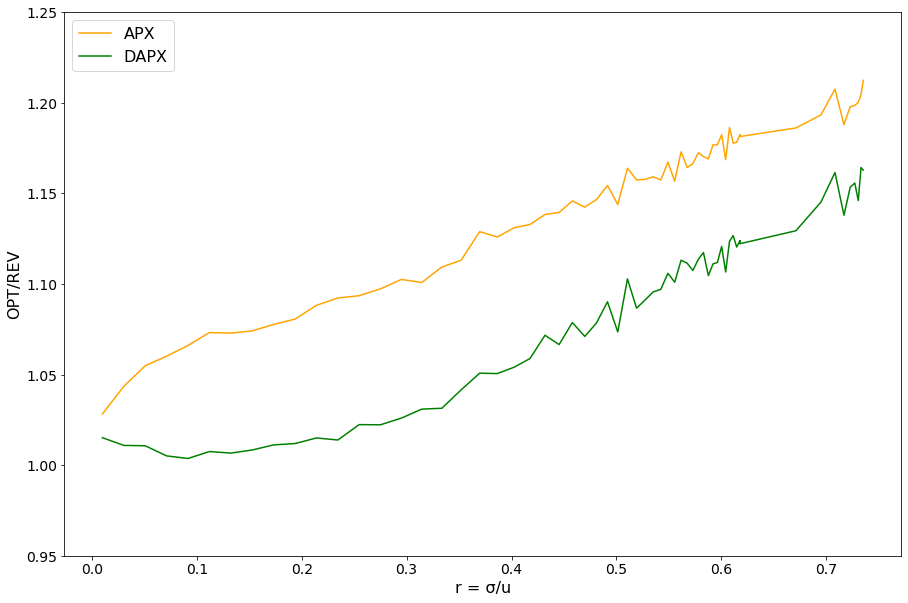

In [51]:
plt.figure(figsize=(15,10))
plt.tick_params(axis='x', labelsize= 14)
plt.tick_params(axis='y', labelsize= 14)
plt.xlabel("r = \u03C3/u",fontsize=16)
plt.ylabel("OPT/REV",fontsize=16)
plt.plot(r_list, APX_tnorm_list,color="#FFA500",label="APX")
plt.plot(r_list, DAPX_tnorm,color="green",label="DAPX")

plt.ylim(0.95,1.25)
#plt.plot(r_list, ratio,color="blue",label="worst case rho_d")
#lower_bound = 1+np.log(1+np.power(r_list,2))
#plt.plot(r_list, lower_bound,color="skyblue",label="lower bound 1+ln(1+r^2) ")
plt.legend(loc="upper left",fontsize = 16)
plt.savefig("apxtnorm.png",bbox_inches='tight')
plt.show()

In [4]:
import pandas as pd 
  
# creating the DataFrame 
my_df = { 'r' : r_list,
          'DAPX_tnorm': DAPX_tnorm,
         'APX_tnorm_list': APX_tnorm_list 
         } 
df = pd.DataFrame(my_df) 
  
   
# saving the DataFrame as a CSV file 
gfg_csv_data = df.to_csv('result_tnorm.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data) 

NameError: ignored

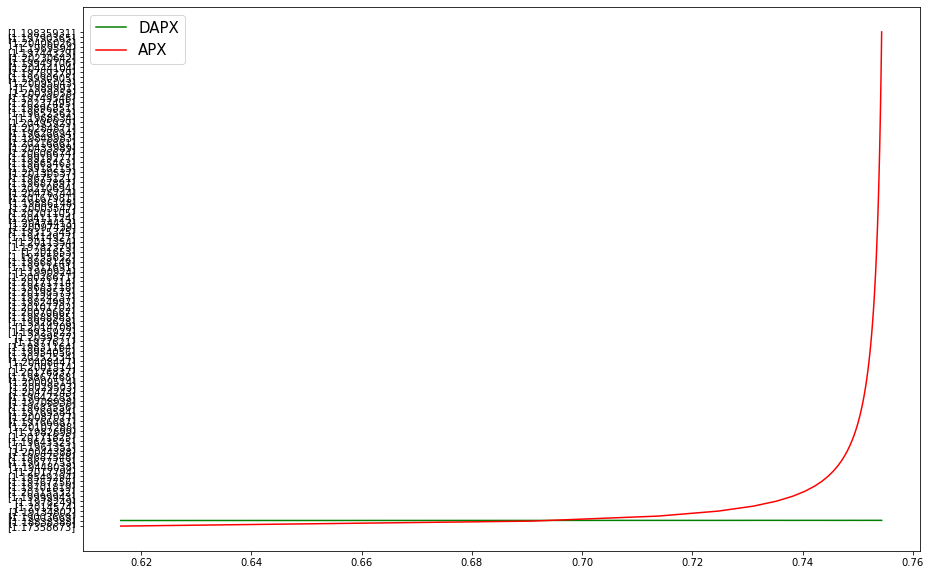

In [23]:
df = pd.read_csv('result_tnorm.csv')

plt.figure(figsize=(15,10))
plt.plot(df.r, df.DAPX_tnorm,color="green",label="DAPX")
plt.plot(df.r, df.APX_tnorm_list,color="red",label="APX")

plt.legend(loc="upper left",fontsize = 15)
plt.show()

In [22]:
df.APX_tnorm_list

0     [1.17358673]
1     [1.18838388]
2     [1.19003669]
3     [1.19134802]
4      [1.2014574]
          ...     
95    [1.19744329]
96     [1.1969594]
97    [1.20406026]
98    [1.19790365]
99    [1.19835931]
Name: APX_tnorm_list, Length: 100, dtype: object

In [3]:
plt.figure(figsize=(15,10))
plt.plot(r_list, DAPX_tnorm,color="green",label="DAPX")
plt.plot(r_list, APX_tnorm_list,color="red",label="APX")
#plt.plot(r_list, ratio,color="blue",label="worst case rho_d")
lower_bound = 1+np.log(1+np.power(r_list,2))
plt.plot(r_list, lower_bound,color="skyblue",label="lower bound 1+ln(1+r^2) ")
plt.legend(loc="upper left",fontsize = 15)
plt.show()

NameError: ignored

<Figure size 1080x720 with 0 Axes>

In [29]:
def f_random(x):
   return ((1/(x**2))*(2*np.exp(x-1)-1) - r**2 - 1 )   
ratio = []
for k in r_list:
  r = k
  ratio.append(fsolve(f_random, [r]))


In [36]:
lower_bound = 1+np.log(1+np.power(r_list,2))





In [ ]:
u = 11.0 
sigma = 10
k2 = u**2 + sigma**2
def f(x):
  return (x * (1 + np.log(k2/(x**2) + 1) - np.log(2)) -u )
 

pi1 = fsolve(f, [u])
pi2 = 0.5*(k2/pi1 +pi1)
print(pi1, pi2)
print(u**2, k2)

[3.22869269] [35.83872468]
121.0 221.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


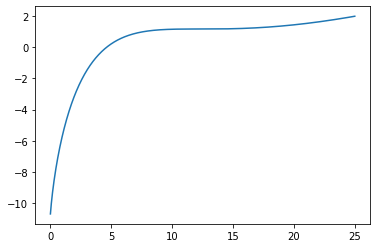

In [ ]:
x = np.linspace(0, 25, 1000)
plt.plot(x,x * (1 + np.log(k2/(x**2) + 1) - np.log(2)) -u )